---
title: "Buy vs. Rent, A Financial Modeling Workflow in Python"
bibliography: "../../blog.bib"
author: "Peter Amerkhanian"
date: "2022-8-6"
description: "Using `numpy-financial` and monte-carlo simulation to evaluate investments."
draft: false
categories:  ['Python', 'Probability']
format:
  html:
    toc: true
    toc-depth: 3
    code-fold: false
    code-tools: true
---

In [1]:
import pandas as pd
import numpy as np
import numpy_financial as npf
from datetime import datetime
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm

We now simulate market returns for every month by supplying mean and standard deviation values for both home and stock market appreciation and drawing 360 samples (360 months in 30 years). For simplicity, we'll just use world-wide aggregate values from ["The Rate of Return on Everything, 1870-2015"](https://www.frbsf.org/economic-research/wp-content/uploads/sites/4/wp2017-25.pdf).


In [2]:
mu_stock = .1081
sigma_stock = .2267

mu_home = .0572
sigma_home = .1042

Given that stock and home appreciation is probably correlated, I'll have ti sample from a bivariate normal distribution using `numpy.random.Generator.multivariate_normal` - documentation [here](https://numpy.org/doc/stable/reference/random/generated/numpy.random.Generator.multivariate_normal.html), rather than the univariate distribution draw shown above. I am going to assume a correlation coefficient, $\rho_{stock,home}$ of 0.5 - a fairly clear correlation.  
In order to use that numpy function, I'll need to translate my correlation statistic into a covariance statistic, and I'll use the following formula ([source](https://en.wikipedia.org/wiki/Correlation)):  
$$ \begin{align*}
cov_{stock,home} &= \rho_{stock,home} \times \sigma_{stock} \sigma_{home} \\\
cov_{stock,home} &= 0.5 \times .2267 \times .1042 \end{align*}
$$

I calculate covariance and confirm that the covariance and correlations match up below:


In [3]:
cov = 0.5 * sigma_stock * sigma_home
print("Covariance:", cov)
print("Back to correlation:", cov / (sigma_stock * sigma_home))

Covariance: 0.01181107
Back to correlation: 0.5


Now that I have the covariance, I'll be able to sample from a bivariate normal distribution of the form shown below ([source](https://en.wikipedia.org/wiki/Multivariate_normal_distribution#Bivariate_case_2)).    
$$
\begin{pmatrix} Stock \\\\ Home\end{pmatrix} \sim \mathcal{N} \left[ \begin{pmatrix} \mu_{s} \\\ \mu_{h}\end{pmatrix}, \begin{pmatrix} \sigma_{s}^2 & cov_{s,h} \\\ cov_{s,h} & \sigma_{h}^2\end{pmatrix} \right]
$$  

*Note, $s$ is shorthand for stock and $h$ is shorthand for home.*  
  
Now I'll code that in Python and confirm that the means and standard deviations of our samples match what we expect:


In [181]:
def simulate_returns(mu_stock=.1081,
                     sigma_stock=.2267,
                     mu_home=.0572,
                     sigma_home=.1042,
                     condo_cost = .02,
                     seed=None):
    cov = 0.5 * sigma_stock * sigma_home
    cov_matrix = np.array([[sigma_stock**2, cov],
                [cov, sigma_home**2]])
    returns_df = pd.DataFrame(np.random
                            .default_rng(seed)
                            .multivariate_normal([mu_stock, mu_home],
                                                cov_matrix,
                                                360),
                            columns=["Stock_Appreciation", "Home_Appreciation"])
    returns_df['Stock_Appreciation'] = returns_df['Stock_Appreciation'] * .7
    returns_df['Condo_Appreciation'] = returns_df['Home_Appreciation'] - condo_cost + np.random.normal(0, .005, len(returns_df))
    returns_df = (returns_df / 12)
    return returns_df

In [182]:
simulate_returns()

,Stock_Appreciation,Home_Appreciation,Condo_Appreciation
0,0.013383,0.002792,0.000932
1,0.007488,-0.005803,-0.007584
2,0.019314,0.011887,0.010240
3,0.025060,0.010326,0.009071
4,-0.003184,-0.006108,-0.008410
...,...,...,...
355,0.007146,0.009000,0.007442
356,0.028599,0.010862,0.009006
357,0.019477,0.003645,0.002221
358,-0.009019,0.003085,0.001267


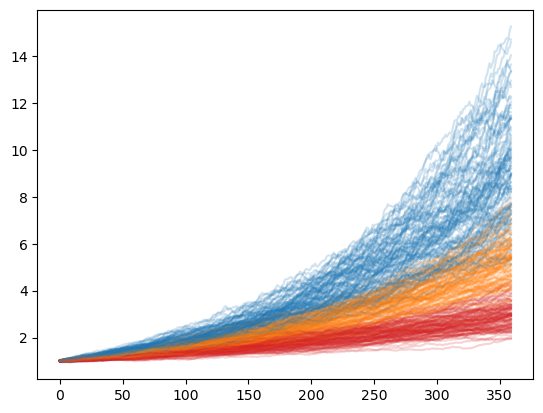

In [183]:
fig, ax = plt.subplots()
for i in range(100):
    returns_df = simulate_returns()
    cum_returns = returns_df.add(1).cumprod()
    cum_returns['Home_Appreciation'].plot(alpha=.2, ax=ax, legend=False, color="tab:orange")
    cum_returns['Condo_Appreciation'].plot(alpha=.2, ax=ax, legend=False, color="tab:red")
    cum_returns['Stock_Appreciation'].plot(alpha=.2, ax=ax, legend=False, color="tab:blue")

In [184]:
def salt_deduction_decision(property_tax):
    """Caps SALT deduction (property + state income tax) at $10,000"""
    return np.minimum(property_tax, 10000)

def itemized_vs_standard_deduction(itemized, standard_deduction=14600):
    """Chooses the better deduction (standard or itemized)"""
    return np.maximum(itemized, standard_deduction)

def apply_compounding(growth, start, deposits):
    growth = np.array(growth)
    deposits = np.array(deposits)
    balance = float(start)
    balances = []
    for i in range(len(growth)):
        balance = (balance + deposits[i]) * (1 + growth[i])
        balances.append(balance)
    return balances

In [185]:
returns_df = simulate_returns()

In [186]:
def owner_table(interest_rate=0.065,
                renovation=0,
                cost=900000,
                hoa=0,
                returns_df=returns_df,
                mean_reno_return=.5,
                cg_tax=.15,
                buying_fees=0.04,
                pct_down=.2,
                condo=False):
    
    down_payment = cost * pct_down
    principal = cost - down_payment
    buying_fees = principal*.04
    reno_return = np.random.lognormal(np.log(mean_reno_return), 0.2)
    post_reno_value = (cost + renovation * reno_return)

    df_own = pd.DataFrame()
    df_own["Period"] =  pd.Series(range(12*30)) + 1
    df_own["Date"] = pd.date_range(
        start=datetime.today().date(),
        periods=12*30,
        freq='MS',
        name="Date")
    df_own = df_own.set_index('Date')
    is_year = df_own.index.month == 1
    year = is_year.cumsum()
    df_own["Purchase_cost"] = buying_fees + down_payment + renovation
    df_own["Principal_monthly"] = npf.ppmt(interest_rate/12,
                                        df_own["Period"],
                                        12*30,
                                        principal) * -1
    df_own["Interest_monthly"] = npf.ipmt(interest_rate/12,
                                        df_own["Period"],
                                        12*30,
                                        principal) * -1
    df_own['HOA_monthly'] = hoa
    df_own["PropTax_monthly"] = np.round((cost * 1.02**((year)) * 0.0124) / 12, 2)
    annual_proptax = df_own.resample("YE")['PropTax_monthly'].sum().rename("PropTax_annual").reindex(df_own.index, method="bfill")
    df_own = df_own.merge(
        annual_proptax, left_index=True, right_index=True, how="left"
        )
    annual_interest = df_own.resample("YE")['Interest_monthly'].sum().rename("Interest_annual").reindex(df_own.index, method="bfill")
    df_own = df_own.merge(
        annual_interest, left_index=True, right_index=True, how="left"
        )
    df_own['Total_deduction'] = itemized_vs_standard_deduction(
        df_own['Interest_annual'] + df_own["PropTax_annual"].apply(salt_deduction_decision)
        )
    df_own['Tax_Savings_annual'] = (df_own['Total_deduction'] * 0.24 + df_own['Total_deduction'] * 0.093)
    df_own['Tax_Savings_monthly'] = df_own['Tax_Savings_annual'] / 12
    df_own['Pre_tax_monthly'] = df_own[["Principal_monthly", "Interest_monthly", "PropTax_monthly", "HOA_monthly"]].sum(axis=1)
    df_own['Post_tax_monthly'] = df_own['Pre_tax_monthly'] - df_own['Tax_Savings_monthly']
    df_own["Balance_Remaining"] = principal - df_own["Principal_monthly"].cumsum()
    if condo:
        df_own["Home_Value"] = apply_compounding(growth=returns_df['Condo_Appreciation'],
                                            start=post_reno_value,
                                            deposits=np.zeros_like(returns_df['Condo_Appreciation'])
                                            ) 
    else:
        df_own["Home_Value"] = apply_compounding(growth=returns_df['Home_Appreciation'],
                                                start=post_reno_value,
                                                deposits=np.zeros_like(returns_df['Home_Appreciation'])
                                                ) 
    df_own["Sale_fee"] = df_own["Home_Value"] * .07
    df_own['Gain'] = (df_own["Home_Value"] - cost)
    df_own["Sale_tax"]  = np.maximum(0, (df_own['Gain'] - 500000)) * cg_tax
    df_own['Profit'] = df_own['Gain'] - df_own["Sale_tax"] - df_own["Sale_fee"] - buying_fees
    return df_own

In [187]:
def compare(scenario_1, scenario_2, returns_df, verbose=False, max_monthly=7500, max_down=300000):
    series_1 = owner_table(**scenario_1)
    series_2 = owner_table(**scenario_2)
    both = [series_1, series_2]
    larger_monthly = np.argmax([s['Post_tax_monthly'].iloc[0] for s in both])
    smaller_monthly = np.argmin([s['Post_tax_monthly'].iloc[0] for s in both])
    if verbose:
        print(scenario_1['cost'])
        print("\tmonthly postax", series_1['Post_tax_monthly'].iloc[0])
        print("\tmonthly pretax", series_1['Pre_tax_monthly'].iloc[0])
        print(scenario_2['cost'])
        print("\tmonthly postax", series_2['Post_tax_monthly'].iloc[0])
        print("\tmonthly pretax", series_2['Pre_tax_monthly'].iloc[0])

    monthly_diff = (both[larger_monthly])['Post_tax_monthly'] - (both[smaller_monthly])['Post_tax_monthly']
    monthly_savings_invested = apply_compounding(returns_df['Stock_Appreciation'],
                                                0,
                                                monthly_diff)

    total_cost_1 = series_1['Purchase_cost'].iloc[0]
    total_cost_2 = series_2['Purchase_cost'].iloc[0]
    larger_upfront = np.argmax([s['Purchase_cost'].iloc[0] for s in both])
    smaller_upfront = np.argmin([s['Purchase_cost'].iloc[0] for s in both])
    if verbose:
        print(scenario_1['cost'])
        print("\tupfront cost", total_cost_1)
        print(scenario_2['cost'])
        print("\tupfront cost", total_cost_2)
        print("\tDifference", (max(total_cost_1, total_cost_2) - min(total_cost_1, total_cost_2)))

    upfront_savings_invested = apply_compounding(returns_df['Stock_Appreciation'],
                                                (max(total_cost_1, total_cost_2) - min(total_cost_1, total_cost_2)),
                                                np.zeros_like(returns_df['Stock_Appreciation']))
    both[smaller_upfront]['Profit'] = both[smaller_upfront]['Profit'].add(upfront_savings_invested).multiply(.85)
    both[smaller_monthly]['Profit'] = both[smaller_monthly]['Profit'].add(monthly_savings_invested).multiply(.85)
    ##
    savings_1 = (max_down - total_cost_1) if (max_down - total_cost_1) > 0 else 0
    both[0]['Profit'] = both[0]['Profit'].add(apply_compounding(returns_df['Stock_Appreciation'],
                                                                savings_1,
                                                                np.zeros_like(returns_df['Stock_Appreciation']))
                                                                ).multiply(.85)
    savings_2 = (max_down - total_cost_2) if (max_down - total_cost_2) > 0 else 0
    both[1]['Profit'] = both[1]['Profit'].add(apply_compounding(returns_df['Stock_Appreciation'],
                                                                savings_2,
                                                                np.zeros_like(returns_df['Stock_Appreciation']))
                                                                ).multiply(.85)
    ##
    ##
    diff_0 = max_monthly - both[0]['Post_tax_monthly']
    diff_0[diff_0 < 0] = 0
    both[0]['Profit'] = both[0]['Profit'].add(apply_compounding(returns_df['Stock_Appreciation'],
                                                                0,
                                                                diff_0)
                                                                ).multiply(.85)
    diff_1 = max_monthly - both[1]['Post_tax_monthly']
    diff_1[diff_1 < 0] = 0
    both[1]['Profit'] = both[1]['Profit'].add(apply_compounding(returns_df['Stock_Appreciation'],
                                                                0,
                                                                diff_1)
                                                                ).multiply(.85)
    ##

    final_profit_1 = both[0]['Profit'].iloc[-1]
    final_profit_2 = both[1]['Profit'].iloc[-1]
    if verbose:
        print(scenario_1['cost'])
        print("\tFinal", final_profit_1)
        print(scenario_2['cost'])
        print("\tFinal", final_profit_2) 
    return both 

916000
	monthly postax 4354.218028804177
	monthly pretax 5578.32447615645
1100000
	monthly postax 5235.253281587986
	monthly pretax 6698.868606738096
916000
	upfront cost 222512.0
1100000
	upfront cost 265200.0
	Difference 42688.0
916000
	Final 5774899.495099886
1100000
	Final 4914606.559426692


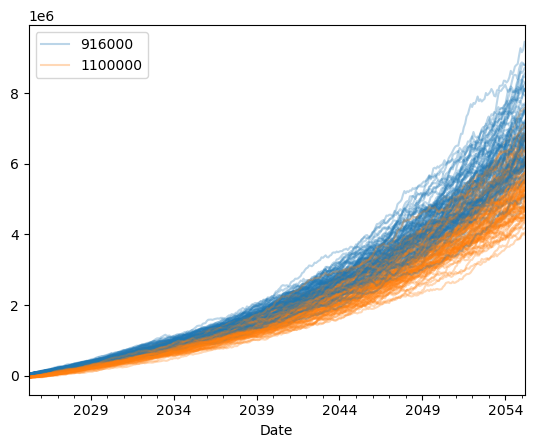

In [188]:
fig, ax = plt.subplots()
profits = {}
yr_10 = {}
yr_20 = {}
ir = 0.065

for i in range(100):
    returns_df = simulate_returns()
    # No Reno
    scenario_1 = {'cost': 916000, 'renovation': 10000, 'returns_df': returns_df, 'pct_down': .2, 'interest_rate':ir}
    # Reno
    scenario_2 = {'cost': 1100000, 'renovation': 10000, 'returns_df': returns_df, 'pct_down': .2, 'interest_rate':ir}
    if i == 0:
        both = compare(scenario_1, scenario_2, returns_df, verbose=True)
        profits[str(scenario_1['cost'])] = []
        profits[str(scenario_2['cost'])] = []
        profits[str(scenario_1['cost'])].append(both[0]['Profit'].iloc[-1])
        profits[str(scenario_2['cost'])].append(both[1]['Profit'].iloc[-1])
        yr_10[str(scenario_1['cost'])] = []
        yr_10[str(scenario_2['cost'])] = []
        yr_10[str(scenario_1['cost'])].append(both[0]['Profit'].iloc[10*12])
        yr_10[str(scenario_2['cost'])].append(both[1]['Profit'].iloc[10*12])
        yr_20[str(scenario_1['cost'])] = []
        yr_20[str(scenario_2['cost'])] = []
        yr_20[str(scenario_1['cost'])].append(both[0]['Profit'].iloc[20*12])
        yr_20[str(scenario_2['cost'])].append(both[1]['Profit'].iloc[20*12])
        both[0]['Profit'].plot(ax=ax, label=str(scenario_1['cost']), color="tab:blue", alpha=.3)
        both[1]['Profit'].plot(ax=ax, label=str(scenario_2['cost']), color="tab:orange", alpha=.3)
    else:
       both = compare(scenario_1, scenario_2, returns_df)
       profits[str(scenario_1['cost'])].append(both[0]['Profit'].iloc[-1])
       profits[str(scenario_2['cost'])].append(both[1]['Profit'].iloc[-1])
       yr_10[str(scenario_1['cost'])].append(both[0]['Profit'].iloc[10*12])
       yr_10[str(scenario_2['cost'])].append(both[1]['Profit'].iloc[10*12])
       yr_20[str(scenario_1['cost'])].append(both[0]['Profit'].iloc[20*12])
       yr_20[str(scenario_2['cost'])].append(both[1]['Profit'].iloc[20*12])
       both[0]['Profit'].plot(ax=ax, label="_k", color="tab:blue", legend=False, alpha=.3)
       both[1]['Profit'].plot(ax=ax, label="_l", color="tab:orange", legend=False, alpha=.3) 
ax.legend();

#### 10 yr

In [189]:
mod = sm.regression.quantile_regression.QuantReg.from_formula("value ~ I(variable)", data =pd.DataFrame(yr_10).melt()).fit(q=0.5)
mod.summary().tables[-1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,8.915e+05,1.32e+04,67.608,0.000,8.65e+05,9.17e+05
I(variable)[T.916000],1.676e+05,1.86e+04,8.986,0.000,1.31e+05,2.04e+05


In [190]:
mod.params.iloc[-1]/10/12

1396.4417523097866

#### 20 yr

In [191]:
mod = sm.regression.quantile_regression.QuantReg.from_formula("value ~ I(variable)", data =pd.DataFrame(yr_20).melt()).fit(q=0.5)
mod.summary().tables[-1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,2.455e+06,5.31e+04,46.201,0.000,2.35e+06,2.56e+06
I(variable)[T.916000],4.575e+05,7.51e+04,6.088,0.000,3.09e+05,6.06e+05


In [192]:
mod.params.iloc[-1]/20/12

1906.2081742463731

#### 30 yr

In [193]:
mod = sm.regression.quantile_regression.QuantReg.from_formula("value ~ I(variable)", data =pd.DataFrame(profits).melt()).fit(q=0.5)
mod.summary().tables[-1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,5.311e+06,1.09e+05,48.851,0.000,5.1e+06,5.53e+06
I(variable)[T.916000],1.339e+06,1.54e+05,8.708,0.000,1.04e+06,1.64e+06


In [194]:
mod.params.iloc[-1]/30/12

3719.0661241270295